# t-SNE Visualization of Amazon reviews with polarity based color-coding

BY: Subham Sarkar

In [3]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# using the SQLite Table to read data.
con = sqlite3.connect('C:/Users/Subham Sarkar/Downloads/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews  WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative


import warnings
warnings.filterwarnings("ignore")


In [4]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape


(364173, 10)

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Subham
[nltk_data]     Sarkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'nor', 'between', 'am', 'has', 'out', 'by', 'too', 'theirs', 'once', 'only', 'was', 'very', 'it', "you've", "she's", 'yours', "don't", 'won', 'yourselves', 'needn', 'we', 'hers', 'above', 'at', 'in', 'further', "mightn't", "mustn't", 'ours', 'shan', "you'll", 'ourselves', 'their', 'own', 'not', 'few', 'me', 'his', 'until', 're', 'a', "aren't", 'him', 'had', 'wouldn', 'd', 'm', 'some', 'here', 'there', 'll', 've', 'as', 'those', "that'll", 'being', "should've", "doesn't", 's', 'against', 'aren', 'most', 'into', 'our', 'you', 'which', 'my', 'such', 'down', 'during', 'mustn', 'itself', "needn't", "won't", 'from', 'other', 'can', "couldn't", 'where', 'be', 'o', "isn't", "wasn't", 'same', 'to', 'both', "shan't", 'before', 'were', "haven't", 'under', 'should', 'ain', 'wasn', 'while', 'for', 'through', 'after', 'didn', "hadn't", 'or', "didn't", 'did', 'over', 'herself', 'is', "you're", 'been', 'why', 'they', 'she', 'any', 'just', 'but', 'so', 'isn', 'your', 'what', 'this', "you'd", 'does', '

In [14]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0;
str1=' ';
final_string=[];
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [15]:
print(final_string)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:

final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [17]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Bag of Words

In [18]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 71624)
the number of unique words  71624


In [19]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


#Observation:- 

From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. 
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [20]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
 
standardized_data=StandardScaler().fit_transform(final_counts[4000].toarray())
print(standardized_data.shape)

(1, 71624)


# t-SNE plot for Bag of Words with perplexity = 30

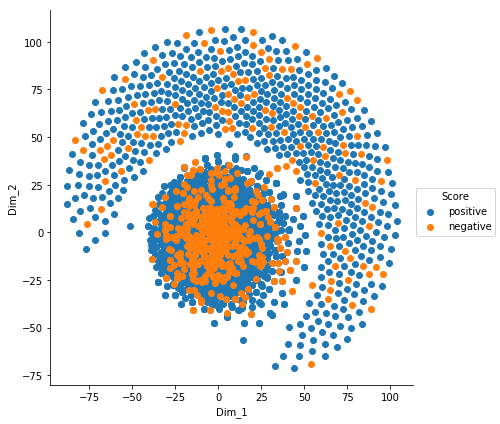

In [30]:
from sklearn.manifold import TSNE
label_4000 = final['Score'][0:4000]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(standardized_data)
tsne_data=np.vstack((tsne_data.T,label_4000)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim_1','Dim_2','Score'))
sns.FacetGrid(tsne_df, hue='Score', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# tf-idf (term frequency-inverse document frequency)

In [21]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 2923725)
the number of unique words including both unigrams and bigrams  2923725


In [22]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100000:100010])

some sample features(unique words in the corpus) ['antler fair', 'antler fall', 'antler fantast', 'antler far', 'antler fault', 'antler favorit', 'antler feel', 'antler french', 'antler get', 'antler girl']


In [28]:
print(final_tf_idf[0:100,:].toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


In [29]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [30]:
top_tfidf

,feature,tfidf
0,page open,0.192673
1,read sendak,0.192673
2,movi incorpor,0.192673
3,paperback seem,0.192673
4,version paperback,0.192673
5,flimsi take,0.192673
6,incorpor love,0.192673
7,rosi movi,0.192673
8,keep page,0.192673
9,grew read,0.192673


In [31]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
 
standardize_data=StandardScaler().fit_transform(final_tf_idf[0:100,:].toarray())
print(standardize_data.shape)

(100, 2923725)


# t-SNE plot of average tf-idf with perplexity = 30
 

In [ ]:
from sklearn.manifold import TSNE
label_4000 = final['Score'][0:4000]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(standardize_data)
tsne_data=np.vstack((tsne_data.T,label_4000)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim_1','Dim_2','Score'))
sns.FacetGrid(tsne_df, hue='Score', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Word2Vec

In [33]:
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [34]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [35]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  21938
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two']


In [37]:
w2v_model.wv.most_similar('tasti')

[('delici', 0.8079195618629456),
 ('yummi', 0.7775864601135254),
 ('tastey', 0.722675621509552),
 ('good', 0.6968026161193848),
 ('nice', 0.6770238876342773),
 ('hearti', 0.6712539196014404),
 ('satisfi', 0.6701481938362122),
 ('nutriti', 0.644965648651123),
 ('great', 0.6448278427124023),
 ('terrif', 0.6447775363922119)]

In [38]:
w2v_model.wv.most_similar('like')

[('weird', 0.7477270364761353),
 ('dislik', 0.7056392431259155),
 ('funki', 0.6866582632064819),
 ('yucki', 0.6820259690284729),
 ('okay', 0.6809946894645691),
 ('prefer', 0.6613717079162598),
 ('gross', 0.6539754271507263),
 ('fake', 0.6539649963378906),
 ('resembl', 0.6470655202865601),
 ('appeal', 0.6464338898658752)]

In [39]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
print(count_vect_feat[count_vect_feat.index('like')])

like


# TF-IDF weighted Word2Vec

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# average Word2Vec

In [49]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

364171
50


# t-SNE plot of average Word2Vec with perplexity = 30

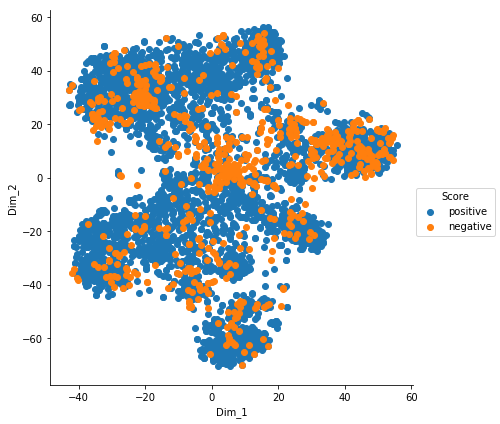

In [54]:
from sklearn.manifold import TSNE
label_4000_avg = final['Score'][0:4000]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(sent_vectors[0:4000])
tsne_data=np.vstack((tsne_data.T,label_4000_avg)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim_1','Dim_2','Score'))
sns.FacetGrid(tsne_df, hue='Score', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()